<center>
    
    COMP4240/5435 - Reinforcement Learning
    
# Homework 4 - Monte Carlo Methods
    
</center>

Student Name:Samuel Mason 

The purpose of this project is to study different properties of Monte Carlo methods.  

**General Notes:**
- Questions marked with * are optional for COMP4240 - Undergraduate section. Questions marked as extra credit are optional for everyone. This homework does not include a separate extra credit question. However, students in COMP4240 can gain some extra credits by solving the last part.
- Do not use a mix of python lists and numpy arrays. Every vector or matrix in your code should be a numpy array. 
- For functions that exist in both the python core and the numpy library, use the one in the numpy library. For example, use `np.max` instead of `max`. Another example: use `np.random.normal` instead of `random.gauss`.
- Make sure all of your plots have a proper size and include `xlabel`, `ylabel`, `legend`, `title`, and `grid`.

In order to use the Blackjack environment for this homework, you should install two python modules.

**Pygame**

Install this module using:
> pip install pygame

**OpenAI gym**
Install this module using:
> pip install gym

In [2]:
# You are allowed to use the following modules
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import gym
# you don't need to import pygame which is a dependency of the gym module

## Using Blackjack from gym

**Description**

Card Values:
- Face cards (Jack, Queen, King) have a point value of 10.
- Aces can either count as 11 (called a ‘usable ace’) or 1.
- Numerical cards (2-9) have a value equal to their number.

This game is played with an infinite deck (or with replacement). The game starts with the dealer having one face up and one face down card, while the player has two face up cards.

The player can request additional cards (hit, action=1) until they decide to stop (stick, action=0) or exceed 21 (bust, immediate loss). After the player sticks, the dealer reveals their facedown card, and draws until their sum is 17 or greater. If the dealer goes bust, the player wins. If neither the player nor the dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.

**Action Space**

There are two actions: 
- stick (0)
- hit (1)

**Observation Space**

The observation consists of a 3-tuple containing: the player’s current sum, the value of the dealer’s one showing card (1-10 where 1 is ace), and whether the player holds a usable ace (0 or 1).

**Rewards**
- win: +1
- lose: -1
- draw: 0


The following code snipet shows how to set up and use Blackjack game:





In [3]:
env = gym.make('Blackjack-v1', natural=False, sab=True)
observation = env.reset()
terminated = False
while not terminated:
    print(f'observation: {observation}') 
    action = np.random.randint(2)
    print(f'action: {action}')
    observation, reward, terminated, truncated = env.step(action)
print(f'reward: {reward}')
env.reset()
env.close()

observation: (15, 10, False)
action: 1
observation: (21, 10, False)
action: 1
reward: -1.0


## Problem
The objective of the popular casino card game of blackjack is to obtain cards that sum of whose numerical values is as great as possible without exceeding 21. All face cards count as 10, and an ace can count either as 1 or as 11. We consider the version in which each player competes independently against the dealer. The game begins with two cards dealt to both dealer and player. One of the dealer’s cards is face up and the other is face down. If the player has 21 immediately (an ace and a 10-card), it is called a natural. He then wins unless the dealer also has a natural, in which case the game is a draw. If the player does not have a natural, then he can request additional cards, one by one (hits), until he either stops (sticks) or exceeds 21 (goes bust). If he goes bust, he loses; if he sticks, then it becomes the dealer’s turn. The dealer hits or sticks according to a fixed strategy without choice: he sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome—win, lose, or draw—is determined by whose final sum is closer to 21. 

Playing blackjack is naturally formulated as an **episodic** finite MDP. Each game of blackjack is an episode. Rewards of +1, −1, and 0 are given for winning, losing, and drawing, respectively. All rewards within a game are zero, and we do not discount ($\gamma=1$); therefore these terminal rewards are also the returns. The player’s actions are to hit or to stick. The states depend on the player’s cards and the dealer’s showing card. We assume that cards are dealt from an infinite deck (i.e., with replacement) so that there is no advantage to keeping track of the cards already dealt. If the player holds an ace that he could count as 11 without going bust, then the ace is said to be usable. In this case it is always counted as 11 because counting it as 1 would make the sum 11 or less, in which case there is no decision to be made because, obviously, the player should always hit. Thus, the player makes decisions on the basis of three variables: his current sum (12–21), the dealer’s one showing card (ace–10), and whether or not he holds a usable ace. This makes for a total of 200 states.




## Part I

1. Write a python function for the player policy that sticks if the player’s sum is 19, 20, or 21, and hits otherwise. The input to this function should be states and the output should be the action. Then use this function to play Blackjack and print out 3 sample trajectories (a trajectory should include a complete game history). 

*(10)(5) points*


In [49]:
#--- Your code here ---#
def player_policy(state):
    if state[0] >= 19:
        return 0
    return 1

for round in range(3):
    observation = env.reset()
    terminated = False
    history = np.empty(0)
    print(f'round: {round}')
    while not terminated:
        print(f'  observation: {observation}') 
        action = player_policy(observation)
        history = np.append(history, action)
        print(f'  action: {action}')
        observation, reward, terminated, truncated = env.step(action)
    print(f'history: {history}')
    print(f'reward: {reward}', end='\n\n')
    env.reset()
env.close()


round: 0
  observation: (20, 10, False)
  action: 0
history: [0.]
reward: 1.0

round: 1
  observation: (11, 2, False)
  action: 1
  observation: (19, 2, False)
  action: 0
history: [1. 0.]
reward: -1.0

round: 2
  observation: (11, 6, False)
  action: 1
  observation: (21, 6, False)
  action: 0
history: [1. 0.]
reward: 1.0



2. Implement the **First-visit Monte Carlo prediction** algorithm and consider the player policy you developed in the previous step. Estimate the state-value function for this policy using the first-visit Monte Carlo prediction algorithm by simulating 500,000 blackjack games using the policy and average the returns following each state. Plot the 3D graph of state-value (z-axis), dealer showing (x-axis), player sum (y-axis) for both usable ace and not usable ace states (i.e., you should have two plots). Your implementation should use the **incremental sample-average**.

*(40)(25) points*


In [1142]:
#--- Your code here ---#
def first_visit_mc_prediction(num_ep):
    
    # store state-value, dealer showing, and player sum
    # with and without usable ace states
    
    # state-value V(s), state history, episode state trajectory, and set for implementing first-step
    V = {}
    V_hist = {}
    trajectory = []
    first_step_reached = set()
    
    # returns(s)
    returns = np.empty(0)
    
    # iterate through number of episodes passed into function
    for round in range(num_ep):
        observation = env.reset()
        terminated = False
        # Generate episode
        while not terminated:
                    
            # add state to V with initialized value if not already a member
            if observation not in V.keys():
                V[observation] = np.random.normal(0, 1)
                # initialize V_hist element to 1 visit otherwise increment
                V_hist[observation] = 1
            else:  
                # increment visited state history
                V_hist[observation] += 1
                
            # push current observation to the front of the trajectory list
            trajectory.insert(0, observation)

            # select action
            action = player_policy(observation)

            # get next step in episode
            observation, reward, terminated, truncated = env.step(action)

            # append current reward to returns array
            returns = np.append(returns, reward)
            
            
        # Calculate returns
        for i, state in enumerate(trajectory):
            if state not in first_step_reached:            
                V[state] =  V[state] + ((1.0 / V_hist[state]) * (reward - V[state]))
                first_step_reached.add(state)
        
        first_step_reached = set()
        trajectory = []
        env.reset()

    env.close()
    return V    

In [1308]:
def display_3d(value_func, title):
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    z = np.array([])
    y = np.array([])
    x = np.array([])
    
    ax.set_title(title)
    ax.set_xlabel('Player Sum')
    ax.set_ylabel('Dealer Showing')
    ax.set_zlabel('State Value')
    
    for value in value_func.values():
        z = np.append(z, value)

    for key in value_func.keys():
        y = np.append(y, key[1])
        x = np.append(x, key[0])

    ax.scatter3D(x, y, z)
    
def display_3d_policy(policy, title):
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    z = np.array([])
    y = np.array([])
    x = np.array([])
    
    ax.set_title(title)
    ax.set_xlabel('Player Sum')
    ax.set_ylabel('Dealer Showing')
    ax.set_zlabel('policy Value')
    
    for action in policy.values():
        z = np.append(z, action)

    for key in policy.keys():
        y = np.append(y, key[1])
        x = np.append(x, key[0])

    ax.scatter3D(x, y, z)

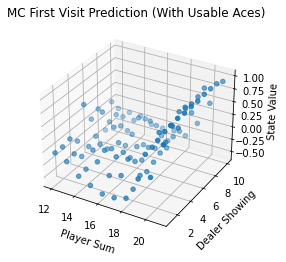

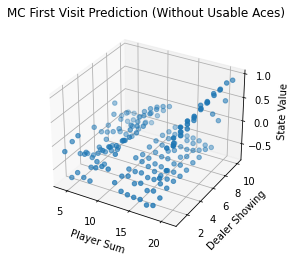

In [1307]:
V = first_visit_mc_prediction(50000)

usable_aces, no_usable_aces = {}, {}

for state in V:
    if state[2]:
        usable_aces[state] = V[state]
    else: 
        no_usable_aces[state] = V[state]  

display_3d(usable_aces, 'MC First Visit Prediction (With Usable Aces)')
display_3d(no_usable_aces, 'MC First Visit Prediction (Without Usable Aces)')

## Part II
1. Use the previous policy (sticks if the player’s sum is 19, 20, or 21, and otherwise hits) as the initial policy and find (i) the action-value estimates and (ii) the optimal policy using Monte Carlo with Exploring Starts. To make the starting states with uniform probabilities, pick the dealer’s cards, the player’s sum, and whether or not the player has a usable ace, according to a uniform sampling process. 

*(30)(15) points*


In [1298]:
def exploring_starts_mc_prediction(num_ep):
    
     # state-value V(s), state history, episode state trajectory, and set for implementing first-step
    Q = {}
    Q_hist = {}
    opt_policy = {}
    trajectory = []
    first_step_reached = set()
    
    # returns(s)
    returns = np.empty(0)
    
    for episode in range(num_ep):
        env = gym.make('Blackjack-v1', natural=False, sab=True)        
        observation = env.reset()
        terminated = False
        while not terminated:
            
#             print(f'observation: {observation}') 
            action = player_policy(observation)
#             print(f'action: {action}')
            
            if observation not in Q.keys():
                Q[observation] = np.array([np.random.normal(0,1), np.random.normal(0,1)])
                Q_hist[observation] = np.array([0,0])
                Q_hist[observation][action] = 1
            else:
                # This is where Q[state][action] is updated
                Q_hist[observation][action] += 1
                
            # push current observation to the front of the trajectory list
            trajectory.insert(0, observation)
            
            # go to next step in episode
            observation, reward, terminated, truncated = env.step(action)
            
            # append current reward to returns array
            returns = np.append(returns, reward)
            
        # calculate returns
        for i, state in enumerate(trajectory):
            if (state, action) not in first_step_reached:
                if Q_hist[state][action] == 0:
                    Q_hist[state][action] += 1
                Q[state][action] = Q[state][action] + ((1.0 / Q_hist[state][action]) * (reward - Q[state][action]))
                first_step_reached.add((state, action))
                opt_policy[state] = np.argmax(Q[state])
                
        first_step_reached = set()
        env.reset()
        env.close()
    return (Q, opt_policy)

2. Plot the 3D graph of state-value (z-axis), dealer showing (x-axis), player sum (y-axis) for both usable ace and not usable ace states (i.e., you should have two plots) for 500,000 simulated games. Also plot the optimal policy for both the usable ace and not usable ace states for all the player’s sum and dealer showing (i.e., you should have two plots).

*(20)(15) points*

In [ ]:
Q, opt_policy = exploring_starts_mc_prediction(50000)

usable_aces, no_usable_aces = {}, {}

for state in V:
    if state[2]:
        usable_aces[state] = V[state]
    else: 
        no_usable_aces[state] = V[state]  

display_3d(usable_aces, 'MC Exploring Starts Prediction (With Usable Aces)')
display_3d(no_usable_aces, 'MC Exploring Starts Prediction (Without Usable Aces)')

for state in opt_policy:
    if state[2]:
        usable_aces[state] = opt_policy[state]
    else: 
        no_usable_aces[state] = opt_policy[state] 

display_3d_policy(usable_aces, 'MC Exploring Starts Optimal Policy (With Usable Aces)')
display_3d_policy(no_usable_aces, 'MC Exploring Starts Optimal Policy (Without Usable Aces)')


## Part III (*)
1. Extend your algorithm to the **off-policy Monte Carlo control with weighted importance sampling** and estimate action-values and the target policy. You need to consider an arbitrary soft behavior policy. Plot the 3D graph of state-value (z-axis), dealer showing (x-axis), player sum (y-axis) for both usable ace and not usable ace states (i.e. you should have two plots) for 500,000 simulated games. Also plot the optimal policy for both the usable ace and not usable ace states for all the player’s sum and dealer showing (i.e. you should have two plots).


*(+10)(30)* points



In [ ]:
#--- Your code here ---#

2. Answer the following questions:

a.	What behavior policy did you select? Why does it make sense?
> Answer 

b.	How does the obtained target policy in this part compare to the target policies in parts I and II? Is it different? Why? 
> Answer

*(+10)(10) points*